Существует множество типов матриц, удовлетворяющих некоторым дополнительным условиям, для которых многие матричные операции могут быть вычислены быстрее или точнее, чем для матриц произвольного вида. 
В данной лабораторной мы начнем писать библиотеку на Python, которая будет содержать классы, реализующие базовые алгоритмы для работы с основными типами матриц.
Далее приводится исходный код класса `Matrix`, являющегося общим предком для всех матриц, и реализующего логику работы с матрицами общего вида.
Нижеследующий класс `FullMatrix` реализует хранилище для заполненных матриц. 
Изучите эти реализации и выполните следующие задания:

1. Напишите метод `lu` для класса `Matrix`, выполняющий LU разложение. +
2. Реализуйте метод `det`, вычисляющий определитель матрицы, опираясь на LU разложение. +
3. Реализация `FullMatrix` может содержать своими элементами другие матрицы, т.е. описывать блочную матрицу. Убедитесь, что ваша реализация LU разложения работает с блочными матрицами. (+)
4. Реализуйте LUP разложение с перестановкой строк. Предъявите матрицу, на которой LUP разложение работает, а LU - нет. +
5. Реализуйте метод прогонки и реализуйте метод `Matrix.solve` для решения линейных систем уравнений. +
6. Реализуйте класс `SymmetricMatrix`, хранящий симметричные матрицы. Убедитесь, что метод `Matrix.lu` корректно работает с этим классом. Модифицируйте этот метод для класса `SymmetricMatrix` так, чтобы он использовал симметричность матрицы и работал в два раза быстрее.
7. Как влияет симметричность матрицы на устойчивость LU разложения?
8. Реализуйте класс `BandMatrix` для хранения ленточных матриц. Убедитесь в работоспособности методов `lu` и `solve`.
9. Воспользуйтесь реализованными классами для решения уравнения Пуассона $\Delta f=g$, использую операцию Лапласа из предыдущей лабораторной.

In [40]:
import numpy as np
from fractions import Fraction
from random import randint
import timeit
import matplotlib.pyplot as plt
from scipy import linalg

In [41]:
class TextBlock:
    def __init__(self, rows):
        assert isinstance(rows, list)
        self.rows = rows
        self.height = len(self.rows)
        self.width = max(map(len,self.rows))
        
    @classmethod
    def from_str(_cls, data):
        assert isinstance(data, str)
        return TextBlock( data.split('\n') )
        
    def format(self, width=None, height=None):
        if width is None: width = self.width
        if height is None: height = self.height
        return [f"{row:{width}}" for row in self.rows]+[' '*width]*(height-self.height)
    
    @staticmethod
    def merge(blocks):
        return [" ".join(row) for row in zip(*blocks)]
    
class Matrix:
    """Общий предок для всех матриц."""
    @property
    def shape(self):
        raise NotImplementedError
    
    @property
    def dtype(self):
        raise NotImplementedError
    
    @property 
    def width(self):
        return self.shape[1]
    
    @property 
    def height(self):
        return self.shape[0]    
        
    def __repr__(self):
        """Возвращает текстовое представление для матрицы."""
        text = [[TextBlock.from_str(f"{self[r,c]}") for c in range(self.width)] for r in range(self.height)]
        width_el = np.array(list(map(lambda row: list(map(lambda el: el.width, row)), text)))
        height_el = np.array(list(map(lambda row: list(map(lambda el: el.height, row)), text)))
        width_column = np.max(width_el, axis=0)
        width_total = np.sum(width_column)
        height_row = np.max(height_el, axis=1)
        result = []
        for r in range(self.height):
            lines = TextBlock.merge(text[r][c].format(width=width_column[c], height=height_row[r]) for c in range(self.width))
            for l in lines:
                result.append(f"| {l} |")
            if len(lines)>0 and len(lines[0])>0 and lines[0][0]=='|' and r<self.height-1:
                result.append(f'| {" "*(width_total+self.width)}|')
        return "\n".join(result)
    
    def empty_like(self, width=None, height=None):
        raise NotImplementedError
    
    def __getitem__(self, key):
        raise NotImplementedError
    
    def __setitem__(self, key, value):
        raise NotImplementedError
        
    def __add__(self, other):
        if isinstance(other, Matrix):
            assert self.width==other.width and self.height==other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(self.width):
                    matrix[r,c] = self[r,c] + other[r,c]
            return matrix
        return NotImplemented
    
    def __sub__(self, other):
        if isinstance(other, Matrix):
            assert self.width==other.width and self.height==other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(self.width):
                    matrix[r,c] = self[r,c] - other[r,c]
            return matrix
        return NotImplemented

    def __mul__(self, other):
        return self.__matmul__(other)
    def __rmul__(self, other):
        return self.__matmul__(other)
    
    def __matmul__(self, other):
        # add matmul for Matrix and number
        if isinstance(other, float or int or Fraction):
            matrix = self.empty_like()
            for c in range(self.height):
                for r in range(self.width):
                    matrix[r,c] = other*self[r,c]
            return matrix 
        if isinstance(other, Matrix):
            assert self.width==other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(other.width):
                    acc = None
                    for k in range(self.width):
                        add = self[r,k]*other[k,c]
                        acc = add if acc is None else acc+add
                    matrix[r,c] = acc
            return matrix
        return NotImplemented
    
    def inverse(self):
        raise NotImplementedError
        
        
    def invert_element(self, element):
        if isinstance(element, float):
            return 1/element
        if isinstance(element, Fraction):
            return 1/element
        if isinstance(element, Matrix):
            return element.inverse()
        raise TypeError
    
#-------ex 1, 3-------------------------

    def __truediv__(self ,other):
        E = FullMatrix.identity(self.height)
        return self*other.solve(E)
    def __rtruediv__(self, other):
        E = FullMatrix.identity(self.height)
        return other*self.solve(E)

    def clone(self):
        copy = np.copy(self.data)
        return FullMatrix(copy)

    def lu(self):
        N = self.height

        if isinstance(self, SymmetricMatrix):
            return self.ldl()
        else:    
            lu_mat = self.clone()
            for i in range(N):
                for j in range(i + 1, N):
                            lu_mat[j, i] /= lu_mat[i, i]
                            for k in range(i + 1, N):
                                lu_mat[j, k] -= lu_mat[j, i] * lu_mat[i, k]
            return lu_mat
    
#-----ex 2------------------------------

    def dissamble_lu(self):
        '''use only for the result of lu'''
        N = self.height

        # copy = self.clone()

        lower = FullMatrix.zero(N, N, Fraction(0))
        upper = FullMatrix.zero(N, N, Fraction(0))

        for i in range(N):
            lower[i, i] = 1
            for j in range(i + 1, N):
                lower[j, i] = self[j, i]

        for i in range(N):
            upper[i, i] = self[i, i]
            for j in range(i + 1, N):
                upper[i, j] = self[i, j]
        return lower, upper
        
    def lu_disassemb(self):
        N = self.height

        l = self.lu()
        
        for i in range(N):
                if type(l[i,i]) == FullMatrix:
                    l[i,i] = FullMatrix.zero(*l[i,i].shape, Fraction(0))
                    for li in range(min(l[i,i].shape)):
                        (l[i,i])[li,li] = Fraction(1)
                    for j in range(i+1, N):
                        l[i,j] = FullMatrix.zero(*l[i,j].shape, Fraction(0))
                else:
                    l[i, i] = 1
                    for j in range(i+1, N):
                        l[i,j] = 0
        u = self.lu()
        
        for i in range(N):
                for j in range(i):
                    if type(u[i,j]) == FullMatrix:
                        u[i,j] = FullMatrix.zero(*u[i,j].shape, Fraction(0))
                    else:
                        u[i,j] = 0

        return l, u
#compare with Grisha
    def get_l(self):
        l = self.lu()
        
        for i in range(l.shape[0]):
                if type(l[i,i]) == FullMatrix:
                    l[i,i] = FullMatrix.zero(*l[i,i].shape, Fraction(0))
                    for li in range(min(l[i,i].shape)):
                        (l[i,i])[li,li] = Fraction(1)
                    for j in range(i+1, l.shape[1]):
                        l[i,j] = FullMatrix.zero(*l[i,j].shape, Fraction(0))
                else:
                    l[i, i] = 1
                    for j in range(i+1, l.shape[1]):
                        l[i,j] = 0
        return l
    
    # student
    def get_u(self):
        u = self.lu()
        for i in range(u.shape[0]):
                for j in range(i):
                    if type(u[i,j]) == FullMatrix:
                        u[i,j] = FullMatrix.zero(*u[i,j].shape, Fraction(0))
                    else:
                        u[i,j] = 0

        return u

    def det(self):
        _, upper = self.lu()

        det = 1

        for i in range(int(self.height)):
            det *= upper[i, i]

        return det

#---- ex 4-----------
        
    def swap_rows(self, row_1, row_2):
        temp = self.clone()
        temp[row_1, :] = self[row_2, :].data
        temp[row_2, :] = self[row_1, :].data
        return temp

    def lup(self):
        N = self.height
        lup = self.clone()
        p = FullMatrix.identity(N)
        for i in range(N):
            compare_val = 0
            compare_row = 0
            for j in range(i, N):
                if abs(lup[j, i]) > compare_val:
                    compare_val = abs(lup[j, i])
                    compare_row = j
            if compare_val != 0:
                #swap
                p = p.swap_rows(compare_row, i)
                lup = lup.swap_rows(compare_row, i)
                for j in range(i + 1, N):
                    lup[j, i] /= lup[i, i]
                    for k in range(i + 1, N):
                        lup[j, k] -= lup[j, i] * lup[i, k] 
        return lup, p

    def transpose(self):
        t = self.data
        return FullMatrix(t.T)


#----ex 5----------------------------

    def solve(self, b):
        N = self.height
        M = b.width
        x = FullMatrix.zero(N, M, Fraction(0, 1))
        y = FullMatrix.zero(N, M, Fraction(0, 1))
        #Ax = b <-> LUx = b <-> Ly = b
        lu, p = self.lup()
        l, u = lu.dissamble_lu()
        pb = p * b

        for i_ in range(M):
            for i in range(N):
                y[i, i_] = pb[i, i_] - sum([l[i, j] * y[j, 0] for j in range(i)])

            #Ux = y

            for i in range(N - 1, -1, -1):
                x[i, i_] = (y[i, i_] - sum([u[i, j] * x[j, i_] for j in range(N - 1, i, -1)])) / u[i, i]

        return x

class FullMatrix(Matrix):
    """
    Заполненная матрица с элементами произвольного типа.
    """
    def __init__(self, data):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data

    def empty_like(self, width=None, height=None):
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]       
        data = np.empty((height,width), dtype=dtype)
        return FullMatrix(data)
        
    @classmethod
    def zero(_cls, height, width, default=0):
        """
        Создает матрицу размера `width` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty((height, width), dtype=type(default))
        data[:] = default
        return FullMatrix(data)
    
    def identity(N):
        E = FullMatrix.zero(N, N, Fraction(0, 1))
        for i in range(N):
            E[i, i] = Fraction(1, 1)
        return E
                    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def dtype(self):
        return self.data.dtype
        
    def __getitem__(self, key):
        row, column = key
        return self.data[row, column]
    
    def __setitem__(self, key, value):
        row, column = key
        self.data[row, column] = value

#------------ex 6-------------

class SymmetricMatrix(Matrix):
    """
    Симметричная матрица с элементами произвольного типа.
    """
    def __init__(self, data):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data

    def empty_like(self, width=None, height=None):
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]       
        data = np.empty((height,width), dtype=dtype)
        return SymmetricMatrix(data)
        
    @classmethod
    def zero(_cls, height, width, default=0):
        """
        Создает матрицу размера `width` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty((height, width), dtype=type(default))
        data[:] = default
        return SymmetricMatrix(data)
                    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def dtype(self):
        return self.data.dtype
        
    def __getitem__(self, key):
        row, column = key
        if row > column:
            row, column = column, row
        return self.data[row, column]
    
    def __setitem__(self, key, value):
        row, column = key
        if row > column:
            row, column = column, row
        self.data[row, column] = value

    def ldl(self):
        N = self.height
        u = self.clone()
        for i in range(N - 1):
            u[i + 1:, i] = u[i, i + 1:]
        for i in range(N - 1):
            for j in range(i + 1, N):
                subst = u[i, i:].data
                subst = np.divide(subst, u[i, i])
                subst = np.multiply(subst, u[j, i])
                u[j, i:] = np.subtract(u[j, i:], subst)
        #now l 
        l = u.clone()
        for i in range(N):
            l[i, i:] = np.divide(l[i, i:], l[i, i])
        l = l.transpose()
        return l, u



### 1

In [ ]:
m = FullMatrix.zero(4, 4, Fraction(0, 1))
for i in range(m.height):
    for j in range(m.width):
        m[i,j] = randint(1, 20)
print(m)

In [ ]:
l, u = m.lu()

In [ ]:
print('lower:')
print(l)
print('upper:')
print(u)

In [ ]:
print(l * u)

### 2


$$
\begin{pmatrix}
    17 & 18 & 10 & 4 \\
    12 & 5 & 3 & 16 \\
    8 & 9 & 15 & 2 \\
    10 & 10 & 15 & 5 \\
\end{pmatrix}
$$

In [ ]:
d = np.array([[17, 18, 10, 4 ],
                [12, 5 , 3 , 16],
                [8 , 9 , 15, 2 ],
                [10, 10, 15, 5 ]])

d.astype(Fraction)
M = FullMatrix(d)

In [ ]:
print('linalg: ', np.linalg.det(d))

In [ ]:
l, u = m.lu()

In [ ]:
print('det: ', m.det())

По матрице Грише

In [ ]:
def delta(n=4):
    d = FullMatrix.zero(n,n,Fraction(0, 1))

    d[0, 0], d[0, 1] = Fraction(2, 1),  Fraction(1, 1)
    d[n-1, n-1], d[n-1, n-2] = Fraction(2, 1), Fraction(1, 1)

    for i in range(1, d.shape[0]-1):
        d[i, i] = Fraction(2, 1)
        d[i, i+1 % n] = Fraction(1, 1)
        d[i, i-1 % n] = Fraction(1, 1)
    return d

In [ ]:
d = delta()
print(d)

In [ ]:
lgd = (np.array([[2,1,0,0],
          [1,2,1,0],
          [0,1,2,1],
          [0,0,1,2]]))

In [ ]:
print('linalg: ', np.linalg.det(lgd))
print('det: ', d.det())

### 3

Нужно ввести деление для матриц (div и truediv)

In [ ]:
m = FullMatrix.zero(2, 2, Fraction(Fraction(0)))
for i in range(m.height):
    for j in range(m.width):
        m[i, j] = randint(2, 7)
M = FullMatrix.zero(3, 3, m)
for i in range(M.height):
    for j in range(M.width):
        if i != j:
            M[i, j] = FullMatrix.identity(m.height)

In [ ]:
print(M)

In [ ]:
lu = M.lu()

In [ ]:
print(lu)

In [ ]:
l, u = M.lu_disassemb()

In [ ]:
print(l * u)

---

In [ ]:
ts = FullMatrix.zero(2, 2, Fraction(10))
ts[0,1] = Fraction(1)
ts[1,0] = Fraction(1)

e2 = FullMatrix.zero(*ts.shape, Fraction(0))

for i in range(e2.shape[0]):
    e2[i,i] = Fraction(1)

blkM = FullMatrix.zero(3, 3, ts)
for i in range(blkM.shape[0]):
    for j in range(blkM.shape[1]):
        if i!=j:
            blkM[i,j] = e2
blkM
blkM.lu()
l, u = blkM.lu_disassemb()

In [ ]:
print(blkM)

In [ ]:
print(blkM.get_l() * blkM.get_u())

### 4

In [ ]:
contradiction = FullMatrix.zero(4,4, Fraction(0))

for i in range(contradiction.shape[0]):
    for j in range(contradiction.shape[1]):
        contradiction[i, j] = Fraction(1 + i, 1 + j)
print(contradiction)

In [ ]:
try:
    contradiction.lu()
except:
    ZeroDivisionError
    print('Division by zero')

In [ ]:
contradiction.lup()

### 5

In [ ]:
m = FullMatrix.zero(3, 3, Fraction(0, 1))
for i in range(m.height):
    for j in range(m.width):
        m[i,j] = randint(1, 10)
print(m)

b = FullMatrix.zero(3, 1, Fraction(0, 1))
for i in range(b.height):
    for j in range(b.width):
        b[i,j] = randint(1, 20)
print(b)


In [ ]:
lu, p = m.lup()

In [ ]:
print('P * b: \n', p * b)

In [ ]:
sol = m.solve(b)
print(sol)

In [ ]:
print(p * m * sol)

### 6

In [ ]:
S = SymmetricMatrix.zero(3, 3, Fraction(3, 1))
print(type(S))

Тест времени выполнения как для обычной матрицы и как для симметричной

In [73]:
MAT_SIZE = 400

REPEAT_NUMBER = 1

In [74]:
def create_test_matrix(N):
    B = FullMatrix.zero(N, N, 0)
    for i in range(N):
        for j in range(N):
            B[i, j] = np.random.rand() + randint(1, N)
    mat_full = B * B.transpose()
    mat_sym = SymmetricMatrix(mat_full.data)
    return mat_full, mat_sym

def reg_time(mat):
    return timeit.timeit(stmt = "mat.lu()", globals = {'mat': mat}, number = REPEAT_NUMBER)
def reg_time_scipy(mat):
    return timeit.timeit(stmt = "linalg.lu(mat)", setup = 'from scipy import linalg',  globals = {'mat': mat}, number = REPEAT_NUMBER)

In [75]:
N_range = range(int(MAT_SIZE / 10), MAT_SIZE, int(MAT_SIZE / 10))

N_list = [N for N in N_range]
f_time = []
s_time = []
sci_time = []

for n in N_range:
    mat_f, mat_s = create_test_matrix(n)
    mat_sci = mat_f.data
    try:
        f_time.append(reg_time(mat_f))
        s_time.append(reg_time(mat_s))
        sci_time.append(reg_time_scipy(mat_sci))
    except:
        del N_list[N_list.index(n)]

In [76]:
N_cube = [n ** 3 for n in N_range]

In [77]:
print(f'N_list size = {len(N_list)}')
print(f'f_time size = {len(f_time)}')
print(f's_time size = {len(s_time)}')
print(f'sci_time size = {len(sci_time)}')

N_list size = 9
f_time size = 9
s_time size = 9
sci_time size = 9


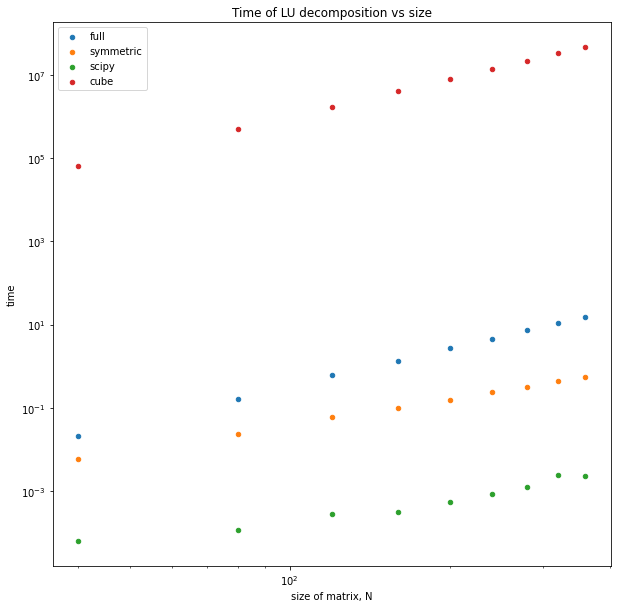

In [78]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter(N_list, f_time, s = 20, label = f'full')
plt.scatter(N_list, s_time, s = 20, label = 'symmetric')
plt.scatter(N_list, sci_time, s = 20, label = 'scipy')
plt.scatter(N_list, N_cube, s = 20, label = 'cube')
plt.xlabel('size of matrix, N')
plt.ylabel('time')
plt.yscale('log')
plt.xscale('log')
plt.title('Time of LU decomposition vs size')
plt.legend()
plt.show()